#### Importando las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from prophet import Prophet

c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


##### Función `analiza_serie` (pipeline que realiza un análisis univariante,
##### búsqueda de parámetros para 3 modelos ARIMA y ajuste de gráfica con un modelo Prophet)

In [2]:
def analiza_serie(ts: pd.Series, label: str, max_p: int = 2, max_q: int = 2):
    """
    Ejecuta análisis univariante completo sobre ts:
      a) Imprime inicio, fin y frecuencia
      b) Grafica la serie
      c) Descompone en tendencia/estacional/residual
      d) Estabiliza varianza via log si hace falta
      e) Test ADF y diferencia para estacionarizar media
      f) Muestra FAC/FACP del resultado
      g) Busca ARIMA(p,d,q) óptimo por AIC
      h) Ajusta y grafica un modelo Prophet
    """
    # a) inicio, fin, freq
    print(f"\n--- {label} ---")
    print("Inicio:", ts.index.min())
    print("Fin   :", ts.index.max())
    print("Freq  :", ts.index.freq)
    
    # b) serie original
    plt.figure(figsize=(10,3))
    plt.plot(ts, label='Nivel')
    plt.title(f"{label} (serie original)")
    plt.xlabel("Fecha"); plt.ylabel("Volumen")
    plt.tight_layout(); plt.show()
    
    # c) descomposición aditiva
    dec = seasonal_decompose(ts, model='additive')
    dec.plot()  
    plt.suptitle(f"Descomposición — {label}", y=1.02)
    plt.tight_layout(); plt.show()
    
    # d) estabilizar varianza si varianza cambió >20%
    var_early = ts.iloc[:36].var()
    var_late  = ts.iloc[-36:].var()
    if abs(var_late - var_early) / var_early > 0.2:
        ts_t = np.log(ts)
        print("→ Aplicación de logaritmo para estabilizar varianza.")
    else:
        ts_t = ts.copy()
        print("→ No requiere transformación de varianza.")
    plt.figure(figsize=(10,3))
    plt.plot(ts_t); plt.title(f"{label} (post-transform)"); plt.show()
    
    # e) test ADF + diferenciación si p>0.05
    plot_acf(ts_t.dropna(), lags=36); plt.title("FAC"); plt.show()
    pval = adfuller(ts_t.dropna())[1]
    if pval > 0.05:
        print(f"ADF p={pval:.3f} > 0.05 → no estacionaria en media. Diferenciar.")
        ts_s = ts_t.diff().dropna()
    else:
        print(f"ADF p={pval:.3f} ≤ 0.05 → estacionaria en media.")
        ts_s = ts_t.copy()
    plt.figure(figsize=(10,3))
    plt.plot(ts_s); plt.title(f"{label} (estac. media)"); plt.show()
    
    # f) FAC/FACP de la serie estacionaria en media
    plot_acf(ts_s, lags=36); plt.title("FAC (estac.)"); plt.show()
    plot_pacf(ts_s, lags=36); plt.title("FACP (estac.)"); plt.show()
    
    # g) búsqueda de ARIMA(p,d,q)
    print("\nBuscando mejor ARIMA(p,d,q) por AIC…")
    ts_arima = ts_t.dropna()
    resultados = []
    for p in range(max_p+1):
        for dval in [0, 1]:
            for q in range(max_q+1):
                # no tratar combinaciones imposibles
                if len(ts_arima) < (p + dval + q + 2):
                    continue
                try:
                    modelo = SARIMAX(
                        ts_arima,
                        order=(p, dval, q),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    res = modelo.fit(disp=False)
                    resultados.append((p, dval, q, res.aic))
                except Exception as e:
                    print(f"  → SARIMAX({p},{dval},{q}) falló: {e.__class__.__name__}")
                    continue

    if not resultados:
        print("No se pudo ajustar ningún ARIMA/SARIMAX en el rango dado.")
    else:
        resultados.sort(key=lambda x: x[3])
        top3 = resultados[:3]
        print("Top 3 SARIMAX(p,d,q) por AIC:", top3)
        p_best, d_best, q_best, aic_best = top3[0]
        mejor = SARIMAX(
            ts_arima,
            order=(p_best, d_best, q_best),
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        print(f"Mejor SARIMAX({p_best},{d_best},{q_best}) — AIC={mejor.aic:.1f}")

    
    # h) Prophet
    dfp = ts_t.reset_index()

    dfp.columns = ['ds', 'y']

    dfp = dfp.dropna(subset=['y'])

    m = Prophet(yearly_seasonality=True, weekly_seasonality=False)
    m.fit(dfp)
    fut = m.make_future_dataframe(periods=12, freq='MS')
    pred = m.predict(fut)

    fig = m.plot(pred)
    fig.suptitle(f"Prophet — {label}", y=1.02)
    plt.tight_layout()
    plt.show

#### Carga de los datos en forma CSV después de la limpieza

In [3]:
df_consumo = pd.read_csv('./df_consumo.csv', index_col='Fecha', parse_dates=True)
df_importacion = pd.read_csv('./df_importacion.csv', index_col='Fecha', parse_dates=True)

#### Generación del análisis univariante, 3 modelos de ARIMA con parámetros ajustados y modelo Prophet
> Nota: Únicamente realizado para Gasolina Regular (Consumo) para esta entrega.



--- Gasolina regular (Consumo) ---
Inicio: 2000-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


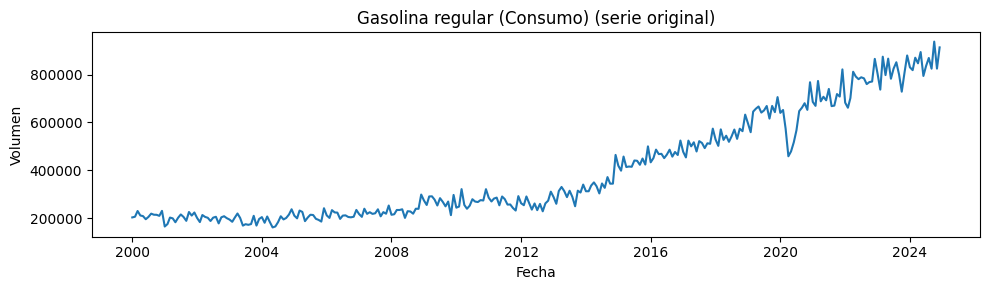

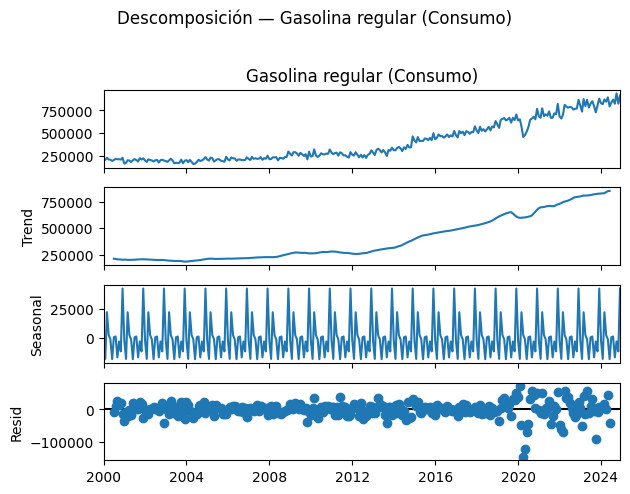

→ Aplicación de logaritmo para estabilizar varianza.


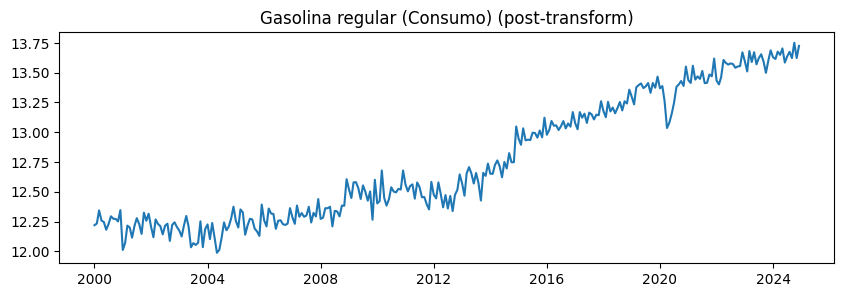

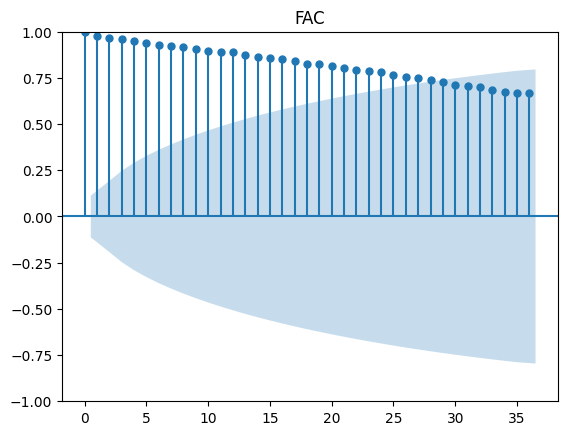

ADF p=0.992 > 0.05 → no estacionaria en media. Diferenciar.


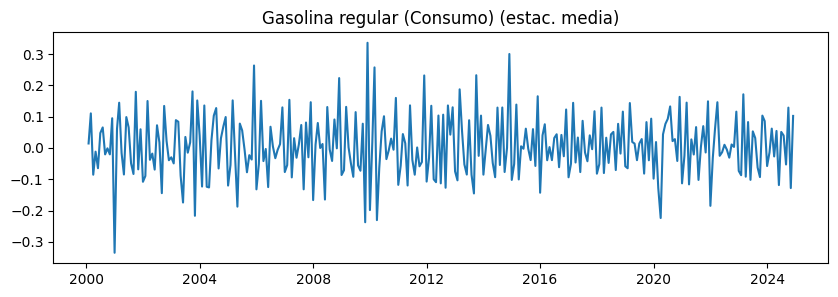

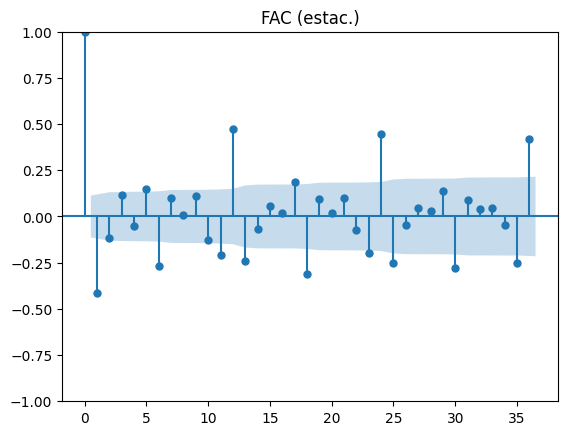

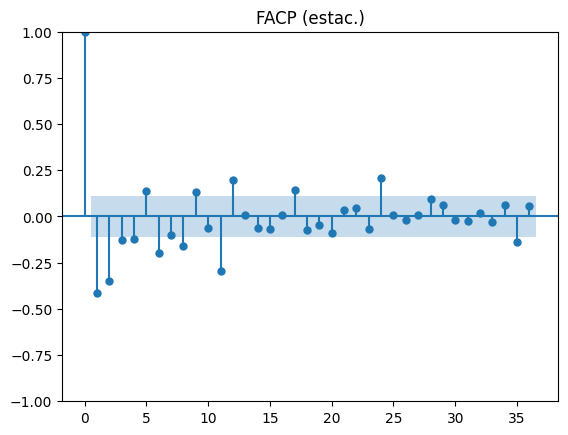


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(1, 0, 1, np.float64(-627.5753964173856)), (1, 0, 2, np.float64(-623.5329774567584)), (2, 0, 2, np.float64(-622.7592073796269))]
Mejor SARIMAX(1,0,1) — AIC=-627.6


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
11:15:17 - cmdstanpy - INFO - Chain [1] start processing
11:15:17 - cmdstanpy - INFO - Chain [1] done processing


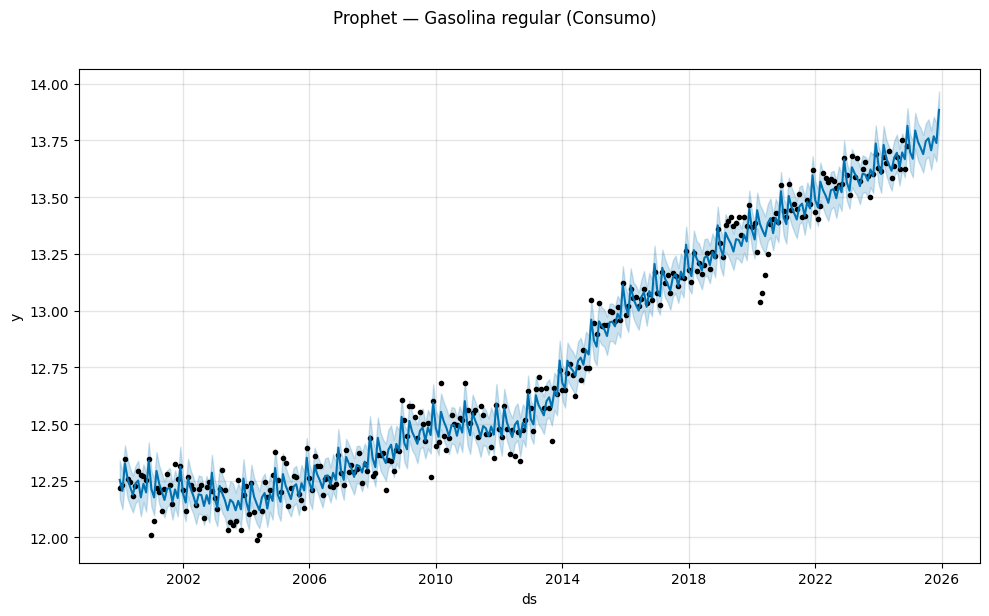

In [4]:
for col in ['Gasolina regular']:
    serie = df_consumo[col].copy()
    serie.name = f"{col} (Consumo)"
    analiza_serie(serie, serie.name)

## Discusión:

<small>

### 1. Serie original
  
- **Tendencia clara y creciente**: desde unos 200 000 barriles en 2000 hasta cerca de 900 000 en 2024.  
- **Variaciones estacionales evidentes**: en cada año se repiten picos y valles (meses de mayor y menor consumo).  
- **Anomalías**: fuerte caída alrededor de 2020, coincidente con los efectos de la pandemia.  

---

### 2. Descomposición aditiva

- **Tendencia (Trend)**: refuerza el crecimiento suave hasta 2014 y luego un empuje más pronunciado hasta 2024.  
- **Estacionalidad (Seasonal)**: patrón anual de amplitud casi constante de ± 25 000 barriles, con picos típicos en ciertos meses (ver gráfico).  
- **Residuales (Resid)**: distribuidos alrededor de cero con dispersión razonablemente homogénea, salvo el “outlier” pandémico.  

---

### 3. Serie tras log-transform

- La transformación logarítmica **comprime** el rango de valores y deja las oscilaciones con **amplitud más constante** a lo largo de todo el periodo.  
- Facilita el modelado si hubiera heterocedasticidad (varianza creciente con el nivel).  

---

### 4. Función de autocorrelación (FAC) sobre la serie transformada

- La **FAC decae muy lentamente** (mantiene valores altos aún en lags > 20), lo que confirma **no-estacionariedad en media**.  
- No hay corte brusco a lag q pequeño, más bien un decaimiento gradual típico de un componente AR(p).  

---

### 5. Serie diferenciada para estacionarizar la media

- Tras diferenciar una vez (d=1), la nueva serie fluctúa alrededor de cero con amplitud bastante constante → **aparentemente estacionaria en media**.  

---

### 6. FAC de la serie estacionaria

- Ahora vemos **picos secundarios** en lags 12, 24 y 36, que indican aún **correlación estacional anual**.  
- Para un ARIMA puro hemos ignorado esta estacionalidad, pero esos picos sugieren que un SARIMA(…,12) podría afinar aún más el ajuste.  

---

### 7. Modelos SARIMAX candidatos

* **Top 3 por AIC**:

  1. SARIMAX(1, 0, 1) AIC = –627.58
  2. SARIMAX(1, 0, 2) AIC = –623.53
  3. SARIMAX(2, 0, 2) AIC = –622.76
* El **mejor** fue **(1,0,1)**, lo que concuerda con la lenta decaída de la FAC y un componente MA(1) que captura la suavización de errores.

---

### 8. Pronóstico con Prophet

* **Prophet** captura automáticamente la **tendencia no lineal** y la **estacionalidad anual**, y ofrece un intervalo de confianza para el pronóstico.
* En muchos casos su **inercia en la tendencia** y manejo explícito de festivos/calendarios puede mejorar la robustez frente a cambios abruptos (como la baja pandémica), pero a cambio sus intervalos suelen ser más amplios que un SARIMAX muy ajustado.

---

**Conclusión para Gasolina Regular (Consumo):**

1. La serie es **no estacionaria** en media y varianza → requiere log-transform y diferenciación (d=1).
2. Un **SARIMAX(1,0,1)** ofrece el mejor equilibrio (AIC más bajo) entre parsimonia y ajuste.
3. La **estacionalidad anual** permanece tras diferenciar, por lo que un SARIMA con componente estacional podría pulir el modelo.
4. **Prophet** resultó competitivo y muy fácil de ajustar, capturando tanto tendencia como estacionalidad, pero con un intervalo de pronóstico más conservador.

</small>